**Approach 2 - Long-Short Term Memory (LSTM's)**<br>
**RUN THIS CELL IF RUNNING IN GOOGLE COLAB**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Automatic Ticket Assignment')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from ProjectModules.PlottingModule import distribution_plot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, GlobalMaxPool1D
from Model.DLModelTuningAndEvaluation import *

installing wordcloud python package...
Done!


**Loading upsampled data from part2a:**

In [ ]:
# RUN THIS DATAPATH IF RUNNING IN GOOGLE COLAB, GIVE THE CORRECT PATH TO THE DATA
DATAPATH = '/content/drive/MyDrive/Automatic Ticket Assignment/DataFiles/'
# *************************** --------------------------************************************
# DATAPATH = 'DataFiles/'

data = pd.read_csv(DATAPATH+"upsampled_processed_data.csv")
df = data.copy() #making copy of the data
print(df.shape)
df.head()

(8040, 4)


,cleaned_short_desc,cleaned_desc,combined_tokens,Assignment group
0,login issue,verify user detail employee manager name check...,login issue verify user detail employee manage...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,outlook team meeting skype meeting etc appear ...,GRP_0
2,cant log vpn,cannot log vpn best,cant log vpn cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr to...,GRP_0
4,skype error,skype error,skype error skype error,GRP_0


**we will drop the combined_tokens column and will create a new combined_tokens column again in a slightly different way. Earlier we simply merged the short description and description column since we had to make bow and tfidf matrix but now since we will be making using of "sequences" we cant have repetitive sequences one after another. We have a lot of records where short description and description are exactly same... hence if they are exactly same we dont want to club them and unnecessarily increase the length of our sequences therefore we will club them in a better way later on:**

In [ ]:
df.drop("combined_tokens", inplace=True, axis=1)
df.head()

,cleaned_short_desc,cleaned_desc,Assignment group
0,login issue,verify user detail employee manager name check...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant log vpn,cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,GRP_0
4,skype error,skype error,GRP_0


**As we explained in part2a before, we removed only those records that had missing values in both description and short description columns. If either of the two had text, we retained it<br>
The missing text was saved with an empty string in the dataframe during pre-processing, but when we converted it to csv and loaded it again, the empty strings display with NaN**

In [ ]:
df.isnull().sum()

cleaned_short_desc    16
cleaned_desc          52
Assignment group       0
dtype: int64

Otherwise if you'll see there is no record where both description and short description are missing: 

In [ ]:
df[(df['cleaned_short_desc'].isnull()) & (df['cleaned_desc'].isnull())]

,cleaned_short_desc,cleaned_desc,Assignment group


So lets fill NaNs with empty string again:

In [ ]:
df['cleaned_short_desc'].fillna(value="",inplace=True)
df['cleaned_desc'].fillna(value = "",inplace=True)

**Making vocabulary:**

In [ ]:
vocabulary = set()

for txt in df["cleaned_desc"]:
    unq_words = set(txt.split())
    vocabulary.update(unq_words)

for txt in df["cleaned_short_desc"]:
    unq_words = set(txt.split())
    vocabulary.update(unq_words)

# appending 'DUMMYWORD' which will be helpful in padding
vocabulary = list(vocabulary)
vocabulary.append("DUMMYWORD")

print("Total unique words in the vocabulary from both description and short description:",len(vocabulary))

Total unique words in the vocabulary from both description and short description: 19235


**Converting vocabulary to numerical values:**

In [ ]:
# mapping vocabulary to numbers
vocab2id = {w: i for i, w in enumerate(vocabulary)}

# mapping numbers to vocabulary
id2vocab = {v: k for k, v in vocab2id.items()}

# transforming dataset to numerical tokens
def convert_words_to_numbers(txt):
  return [vocab2id[i] for i in txt.split()]

# transforming
df["desc_transformed"] = df["cleaned_desc"].apply(convert_words_to_numbers)
df["shortdesc_transformed"] = df["cleaned_short_desc"].apply(convert_words_to_numbers)

**desc_transformed and shortdesc_transformed are the numerical versions of cleaned_short_desc and cleaned_desc columns**


In [ ]:
df.head()

,cleaned_short_desc,cleaned_desc,Assignment group,desc_transformed,shortdesc_transformed
0,login issue,verify user detail employee manager name check...,GRP_0,"[4924, 12794, 8380, 3682, 4240, 8374, 2112, 12...","[3284, 328]"
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0,"[4468, 5887, 12614, 5887, 4959, 15325, 7091, 4...",[7091]
2,cant log vpn,cannot log vpn best,GRP_0,"[13682, 11359, 18032, 16957]","[10937, 11359, 18032]"
3,unable access hr tool page,unable access hr tool page,GRP_0,"[2374, 6200, 18132, 14462, 6902]","[2374, 6200, 18132, 14462, 6902]"
4,skype error,skype error,GRP_0,"[12614, 2286]","[12614, 2286]"


**Combining tokens - like we said we have descriptions and short descriptions that are exactly same. Hence below is a function that returns only description tokens if both are exactly same and if not... it returns description and short description tokens after clubbing them together**

In [ ]:
def clubbing_columns(row):
  if(row["shortdesc_transformed"] == row["desc_transformed"]):
    return row["desc_transformed"]
  else:
    return row["shortdesc_transformed"] + row["desc_transformed"]

In [ ]:
df["combined_tokens"] = df[["shortdesc_transformed","desc_transformed"]].apply(clubbing_columns, axis=1)
df.head()

,cleaned_short_desc,cleaned_desc,Assignment group,desc_transformed,shortdesc_transformed,combined_tokens
0,login issue,verify user detail employee manager name check...,GRP_0,"[4924, 12794, 8380, 3682, 4240, 8374, 2112, 12...","[3284, 328]","[3284, 328, 4924, 12794, 8380, 3682, 4240, 837..."
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0,"[4468, 5887, 12614, 5887, 4959, 15325, 7091, 4...",[7091],"[7091, 4468, 5887, 12614, 5887, 4959, 15325, 7..."
2,cant log vpn,cannot log vpn best,GRP_0,"[13682, 11359, 18032, 16957]","[10937, 11359, 18032]","[10937, 11359, 18032, 13682, 11359, 18032, 16957]"
3,unable access hr tool page,unable access hr tool page,GRP_0,"[2374, 6200, 18132, 14462, 6902]","[2374, 6200, 18132, 14462, 6902]","[2374, 6200, 18132, 14462, 6902]"
4,skype error,skype error,GRP_0,"[12614, 2286]","[12614, 2286]","[12614, 2286]"


**Checking for Null values again:**<br>No missing values

In [ ]:
df.isnull().sum()

cleaned_short_desc       0
cleaned_desc             0
Assignment group         0
desc_transformed         0
shortdesc_transformed    0
combined_tokens          0
dtype: int64

**Lets transform the target variable. We have 74 unique labels in the target class. We will transform the target variable in the one-hot binarizer form:**

In [ ]:
df=pd.get_dummies(df, columns=['Assignment group'])
df.head()

,cleaned_short_desc,cleaned_desc,desc_transformed,shortdesc_transformed,combined_tokens,Assignment group_GRP_0,Assignment group_GRP_1,Assignment group_GRP_10,Assignment group_GRP_11,Assignment group_GRP_12,Assignment group_GRP_13,Assignment group_GRP_14,Assignment group_GRP_15,Assignment group_GRP_16,Assignment group_GRP_17,Assignment group_GRP_18,Assignment group_GRP_19,Assignment group_GRP_2,Assignment group_GRP_20,Assignment group_GRP_21,Assignment group_GRP_22,Assignment group_GRP_23,Assignment group_GRP_24,Assignment group_GRP_25,Assignment group_GRP_26,Assignment group_GRP_27,Assignment group_GRP_28,Assignment group_GRP_29,Assignment group_GRP_3,Assignment group_GRP_30,Assignment group_GRP_31,Assignment group_GRP_32,Assignment group_GRP_33,Assignment group_GRP_34,Assignment group_GRP_35,Assignment group_GRP_36,Assignment group_GRP_37,Assignment group_GRP_38,Assignment group_GRP_39,Assignment group_GRP_4,Assignment group_GRP_40,Assignment group_GRP_41,Assignment group_GRP_42,Assignment group_GRP_43,Assignment group_GRP_44,Assignment group_GRP_45,Assignment group_GRP_46,Assignment group_GRP_47,Assignment group_GRP_48,Assignment group_GRP_49,Assignment group_GRP_5,Assignment group_GRP_50,Assignment group_GRP_51,Assignment group_GRP_52,Assignment group_GRP_53,Assignment group_GRP_54,Assignment group_GRP_55,Assignment group_GRP_56,Assignment group_GRP_57,Assignment group_GRP_58,Assignment group_GRP_59,Assignment group_GRP_6,Assignment group_GRP_60,Assignment group_GRP_61,Assignment group_GRP_62,Assignment group_GRP_63,Assignment group_GRP_64,Assignment group_GRP_65,Assignment group_GRP_66,Assignment group_GRP_67,Assignment group_GRP_68,Assignment group_GRP_69,Assignment group_GRP_7,Assignment group_GRP_70,Assignment group_GRP_71,Assignment group_GRP_72,Assignment group_GRP_73,Assignment group_GRP_8,Assignment group_GRP_9
0,login issue,verify user detail employee manager name check...,"[4924, 12794, 8380, 3682, 4240, 8374, 2112, 12...","[3284, 328]","[3284, 328, 4924, 12794, 8380, 3682, 4240, 837...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,outlook,team meeting skype meeting etc appear outlook ...,"[4468, 5887, 12614, 5887, 4959, 15325, 7091, 4...",[7091],"[7091, 4468, 5887, 12614, 5887, 4959, 15325, 7...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,cant log vpn,cannot log vpn best,"[13682, 11359, 18032, 16957]","[10937, 11359, 18032]","[10937, 11359, 18032, 13682, 11359, 18032, 16957]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,unable access hr tool page,unable access hr tool page,"[2374, 6200, 18132, 14462, 6902]","[2374, 6200, 18132, 14462, 6902]","[2374, 6200, 18132, 14462, 6902]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,skype error,skype error,"[12614, 2286]","[12614, 2286]","[12614, 2286]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Seperating features and target:**

In [ ]:
ynames = list(df.iloc[:,5:].columns)
y = df.iloc[:,5:].values
x = df["combined_tokens"]

print('y (target) in a one-hot binarizer form:',y.shape)
print('features:',x.shape)

y (target) in a one-hot binarizer form: (8040, 74)
features: (8040,)


For every record we have 1 at the group it belongs to otherwise 0


In [ ]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

**Should we use binary_crossentropy or categorical_crossentropy?**<br>
If we have multi-label classification(when a datapoint belongs to multiple classes) we would use binary_crossentropy, but if we have a multi-class classification(when a datapoint belongs to a single classe) we would use a categorical_crossentropy.<br><br>
So for every record we have 1 at the group it belongs to... so if we sum across axis=1 and find the max, it should be 1; which means that we have all 0's except one 1(hot) at the group(class) that particular record belongs to. In other words each datapoint just belongs to 1 class. Hence this is a multi-class classification and thus we will use categorical_crossentropy


In [ ]:
np.sum(y,axis=1).max()

1

**Transforming combined_tokens into sequences**

In [ ]:
x_seq = [seq for seq in x]

 Max no. of tokens in short description (sequence):  1820
 Avg. no. of tokens in short description (sequence):  25.32
 90% of the sequences are <= 46.0
 95% of the sequences are <= 76.05


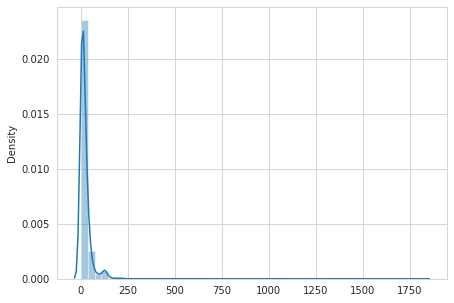

In [ ]:
size_of_sequences = [len(i) for i in x]

percentile90 = round(np.percentile(a=size_of_sequences, q=90),2)
percentile95 = round(np.percentile(a=size_of_sequences, q=95),2)
mean_size = round(np.mean(size_of_sequences),2) 
max_size = round(np.max(size_of_sequences),2)

print(" Max no. of tokens in short description (sequence): ",max_size)
print(" Avg. no. of tokens in short description (sequence): ",mean_size)
print(" 90% of the sequences are <=",percentile90)
print(" 95% of the sequences are <=",percentile95)
distribution_plot(size_of_sequences)

**95% of the sequence is 76.05 or below 76.05 whilst 90% of the sequences are 46 and below 46. Hence we will pad the sequence to 76**<br>
**This means that sequnces greater than 76 will be trimmed down to 76 and sequences less than 76 will be padded to 76, thereby making all the sequences of the same size**<br>
**Since 95% of the sequences in the dataset is <=76, hence it seems to be the apt value for padding**

In [ ]:
len(vocabulary)

19235

**Size of the vocabulary is 19235 i.e words are numbered from 0 - 19234**<br>
Like we said that the sequences that are less than 76 will be padded to be 76, therefore the padding will be done with the number '19234' i.e all padded words will be 19234 and 19234 encodes the word 'DUMMYWORD'. Hence the padding word will be 'DUMMYWORD'<br><br>
**Also we will do pre-padding.** This is because LSTMs are temporal i.e it has timestamps. Hence words coming at the later timestamps are retained more in the 'memory' as compared to the words at the beginning of the sequence. Hence we want dummy words in the beginning of the sequence instead at the end


In [ ]:
# 19234 encodes 'DUMMYWORD'
id2vocab[19234]

'DUMMYWORD'

Pre-Padding with value len(vocabulary)-1 i.e 19234 

In [ ]:
x_pad = pad_sequences(maxlen=76, sequences=x_seq, padding="pre", value=len(vocabulary)-1)

print("shape of x before padding",np.array(x_seq).shape)
print("shape of x after padding",x_pad.shape)

shape of x before padding (8040,)
shape of x after padding (8040, 76)


**Now we can make a 80:20 train test split:**


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pad, y, test_size=0.20, random_state=777, stratify=y)

print("train set",x_train.shape)
print("train labels",y_train.shape,"\n\n")
print("test set",x_test.shape)
print("test labels",y_test.shape)

train set (6432, 76)
train labels (6432, 74) 


test set (1608, 76)
test labels (1608, 74)


**Creating glove embedding for the vocabulary:**<br>
We will try both **pre-trained glove embeddings** and **tensorflow's default embedding training** that tensorflow trains during the training process<br><br>GloVe 200d download link: https://www.kaggle.com/incorpes/glove6b200d

In [ ]:
EMBEDDING_FILE = 'glove.6B.200d.txt'

embeddings = {}
for o in open("/content/drive/My Drive/Automatic Ticket Assignment/"+EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd

# create a weight matrix for words in vocabulary
embedding_matrix = np.zeros((len(vocabulary), 200))

for word, i in vocab2id.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

**All 19235 words have been transformed to corresponding 200 long glove vectors:**<br> We can now use it as the weights in the embedding layer

In [ ]:
embedding_matrix.shape

(19235, 200)

We have imported **Model.DLModelTuningAndEvaluation module**. You can find the DLModelTuningAndEvaluation.py under Model folder.<br>
You will find 3 functions:<br> 
- **train_model()** to train the model for different purposes like test training, hyper-parameter tuning, longer training with callbacks etc.
<br> 
- **show_training()** to show and plot the training process<br>
- **DL_evaluation_metrics()** to evaluate the model on the metrics that we have been using i.e macro F1-Score, macro ROC-AUC and Accuracy


<br>**For more information on the functions please refer to the docstrings below:**

In [ ]:
print(train_model.__doc__)


  Trains models in different ways. You can use this for tuning the deep learning model as well as simple
  training. You can turn on/off callbacks and verbose as per your requirement.

  model: pass your model instance

  xtr: train set
  
  ytr: train labels
  
  xte: test set
  
  yte: test labels
  
  optm: optimizer. Takes string argument. Currently supports Adam (specify 'adam') and RmsProp (specify 'rmsprop')
  
  bs: batch size (default = 32)
  
  learn_rate: learning rate for the optimizer (default = 0.001)
  
  forTuning: when this is true it simply trains the model on the training set and evaluate on both train and test set. 
  It turns off verbose so you can try different learning rates in a loop. Returns trained model, train set metrics
  (accuracy and loss) and test set metrics (accuracy and loss) (Default=False)
  
  callbacks: when this is true it implements model checkpoint, early stopping and ReduceLRPlateau. If this is true,
  the next 3 parameters are compulsory (De

In [ ]:
print(show_training.__doc__)


  Saves and Plots training history. Plots Loss Vs Epoch and Accuracy Vs Epoch graph as well as ReduceLrOnPlateau
  graph (if applicaple)

  history: pass model training distory. If you have previously saved training history, you can pass that or
  else pass model.history.history

  saveit: if True it saves the training history in CSV format at this path: 
  My Drive/capstone/Model/model histories

  filename: name of the csv file to save the history with
  


In [ ]:
print(DL_evaluation_metrics.__doc__)


  Prints Accuracy, F1-Score and ROC-AUC score using Sklearn. Since we have multiclass classification you will need to specify 
  multi-class strategy and averaging strategy.
  NOTE THAT: 
  - ROC-AUC only support macro averaging; while f1-score supports both macro and micro
  - F1-score does not have multi-class parameter hence it does not take 'ovo' or 'ovr' into account. ROC-AUC supports multiclass
  - Accuracy is independent of these two parameters. They are not applicable to accuracy

  ytrue: true labels (array/list/series)
  ypred_proba: predicted probabilities (array/list/series)
  multiclass: multi-class strategy; enter 'ovr' for OneVsRest and 'ovo' for OneVsOne (string)
  avg: averaging strategy; accepts 'micro', 'macro' and 'weighted' (string)
  


**In base approach we will train simple LSTM model with simple architecture, hence we will only be making use of train_model() and DL_evaluation_metrics() in this part**<br><br>
**As we said above that we will try a simple architecture of the LSTM model in this base approach and we will train with default tensorflow embedding layer that will be trained from scratch in the training process only as well as the pre-trained GloVe embedding layer but with trainable = True in order to customise the pre-trained embedding for our corpus**<br>
The model architecture is as follows:<br>
<br>**model1a -**<br>
- input layer of size 76 (x_train.shape[1])<br>
- embedding layer with input_dim = size of the vocabulary, output_dim = 200 and input length = size of input i.e x_train.shape[1]<br>
- LSTM layer with 100 units and return sequence = False<br>
- Output dense layer with units = # labels in the target i.e 74 (y_train.shape[1])

<br>**model1b -** <br>
same as above except embedding layer is initialized with embedding_matrix which is trainable<br><br>
**** We will train with just 10 epochs and batch_size=16*

In [ ]:
# model1a architecture
input = Input(shape=(x_train.shape[1],),batch_size=None)
model1a = Embedding(input_dim=len(vocabulary), output_dim=200, input_length=x_train.shape[1])(input)
model1a = LSTM(units=100, return_sequences=False)(model1a)
out = Dense(y_train.shape[1], activation="softmax")(model1a)
model1a = Model(input, out)
model1a.summary()
print("\n")

# training model1a 
model1a = train_model(model1a, x_train, y_train, x_test, y_test, ep=10, bs=16)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 76, 200)           3847000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_8 (Dense)              (None, 74)                7474      
Total params: 3,974,874
Trainable params: 3,974,874
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
402/402 [==============================] - 36s 89ms/step - loss: 2.4330 - accuracy: 0.4862 - val_loss: 2.0886 - val_accuracy: 0.5267
Epoch 2/10
402/402 [==============================] - 34s 84ms/step - loss: 1.8083 - accuracy: 

In [ ]:
ytr_pred = model1a.predict(x_train)
yte_pred = model1a.predict(x_test)

print("Train set performance:")
DL_evaluation_metrics(y_train, ytr_pred, "ovo", "macro")

print("\nTest set performance:")
DL_evaluation_metrics(y_test, yte_pred, "ovo", "macro")

print("\n**As explained in part2a - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9704601990049752
(macro) ROC-AUC: 0.9993789540709099
(macro) F1 Score: 0.942657489434116

Test set performance:
Accuracy: 0.6380597014925373
(macro) ROC-AUC: 0.8938821743964769
(macro) F1 Score: 0.46343556869866337

**As explained in part2a - micro-metrics will be similar to accuracy


In [ ]:
# model1b architecture
input = Input(shape=(x_train.shape[1],),batch_size=None)
model1b = Embedding(input_dim=len(vocabulary), output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=x_train.shape[1], trainable=True)(input)
model1b = LSTM(units=100, return_sequences=False)(model1b)
out = Dense(y_train.shape[1], activation="softmax")(model1b)
model1b = Model(input, out)
model1b.summary()
print("\n")

# train model1b
train_model(model1b, x_train, y_train, x_test, y_test, ep=10, bs=16)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 76)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 76, 200)           3847000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_9 (Dense)              (None, 74)                7474      
Total params: 3,974,874
Trainable params: 3,974,874
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
402/402 [==============================] - 35s 86ms/step - loss: 2.2227 - accuracy: 0.5216 - val_loss: 1.8459 - val_accuracy: 0.5672
Epoch 2/10
402/402 [==============================] - 34s 83ms/step - loss: 1.5710 - accuracy: 

In [ ]:
ytr_pred = model1b.predict(x_train)
yte_pred = model1b.predict(x_test)

print("Train set performance:")
DL_evaluation_metrics(y_train, ytr_pred, "ovo", "macro")

print("\nTest set performance:")
DL_evaluation_metrics(y_test, yte_pred, "ovo", "macro")

print("\n**As explained in part2a - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9777674129353234
(macro) ROC-AUC: 0.9998745406616154
(macro) F1 Score: 0.9625536675334205

Test set performance:
Accuracy: 0.6666666666666666
(macro) ROC-AUC: 0.9247985445320637
(macro) F1 Score: 0.5134412845374878

**As explained in part2a - micro-metrics will be similar to accuracy


### These were are base models in approach 2. Comparing both the approaches, clearly LSTMs standout! Even with very basic architecture they give almost similar results as compared to base 1 approaches.<br> Within LSTMs also, pre-trained GloVe embedding seems to outshine the tensorflow's default embedding that is trained from scratch during the training process.<br>
### We will thus move on to Milestone 2 and improve upon this existing architecture of the lstm model and tune hyper-parameters. We choose the LSTM with pre-trained GloVe embedding as the model of our choice which we will carry on with in Milestone 2<br>
**But before that lets save the 3 most important files that we will require in milestone 2:**

In [ ]:
# # USE THIS SAVEPATH IF RUNNING IN GOOGLE COLAB, GIVE THE PATH WHERE YOU WANT TO SAVE
# SAVEPATH = '/content/drive/MyDrive/Automatic Ticket Assignment/DataFiles/Milestone2/'
# # *************************** --------------------------************************************
# # SAVEPATH = 'DataFiles/Milestone2/'

# np.save(SAVEPATH+'GloveEmbeddingMatrix.npy', embedding_matrix)
# np.save(SAVEPATH+'xtrain.npy', x_train)
# np.save(SAVEPATH+'ytrain.npy', y_train)
# np.save(SAVEPATH+'xtest.npy', x_test)
# np.save(SAVEPATH+'ytest.npy', y_test)